# Proyecto Final

- Ignacio David Vázquez Perez
- Seminario de Solución de Problemas de Inteligencia Artificial II

In [19]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.compose import make_column_selector
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import seaborn as sns; sns.set()
from matplotlib import pyplot as plt
from sklearn.model_selection import RepeatedStratifiedKFold
from pipelinehelper import PipelineHelper
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LinearRegression
import sys, os
import pandas as pd
import numpy as np
import seaborn as sns; sns.set()
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import RepeatedKFold
import joblib
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.feature_selection import mutual_info_regression
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import f1_score, precision_score, recall_score
import scikitplot as skplt
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)
from warnings import filterwarnings
filterwarnings('ignore')
from sklearn.exceptions import ConvergenceWarning
ConvergenceWarning('ignore')
import warnings
warnings.simplefilter("ignore", category=ConvergenceWarning)
from sklearn.exceptions import ConvergenceWarning


In [3]:
import warnings
warnings.filterwarnings('ignore')

## Funciones

In [4]:
#Visualizar pca em 2D y 3D
class pca():
    def __init__(self,  df=None, titulo="Unspecified", label_y=None):
        self.df = df
        self.label_y = str(label_y)
        self.titulo = str(titulo)
        print(list(df))
        print(f"Numero de elementos de {label_y}\n", df[label_y].value_counts())
    def pca_2D(self):
        df_PCA = self.df.drop([self.label_y], axis=1)
        #instanciamos el metodo pca con 2 componentes
        pca = PCA(n_components=2)
        #encontramos los componentes principales usando 
        #el método de ajuste con 2 componentes
        #transformamos los datos scaled_data en 2 componentes con pca
        pca.fit(df_PCA)
        x_pca = pca.transform(df_PCA)
        ######
        #instanciamos un objeto para hacer PCA
        scaler = StandardScaler()
        #escalar los datos, estandarizarlos, para que cada
        #caracteristica tenga una varianza unitaria 
        scaler.fit(df_PCA)
        #aplicamos la reducción de rotación y dimensionalidad
        scaled_data = scaler.transform(df_PCA)
        pca = PCA().fit(scaled_data)
        plt.plot(np.cumsum(pca.explained_variance_ratio_))
        plt.xlabel('number of components')
        plt.ylabel('cumulative explained variance')
        plt.title('How many components are needed to describe the data.')
        ######
        print("Dimension de los features orginales: ", df_PCA.shape)
        print("Dimension de los features con 2 componentes", x_pca.shape)
        
        #visualizar los datos en 2 dimensiones
        #plt.figure(figsize=(8,6))
        fig, ax = plt.subplots()
        scatter = plt.scatter(x_pca[:,0],
                    x_pca[:,1],
                    c=self.df[self.label_y],
                    cmap='Set1',
                    marker='o',
                    s=4,
                    linewidths=0)
        #genera legend del target
        labels = np.unique(self.df[self.label_y])
        handles = [plt.Line2D([],[],marker=".", ls="", 
                              color=scatter.cmap(scatter.norm(yi))) for yi in labels]
        plt.legend(handles, labels)
        plt.xlabel('First principal component')
        plt.ylabel('Second Principal Component')
        plt.title(self.titulo)
        #plt.show()
        y = self.df[self.label_y]
        return x_pca, y
    def pca_3D(self):
        sns.set_style("white")  
        self.df[self.label_y] = pd.Categorical(self.df[self.label_y])
        my_color = self.df[self.label_y].cat.codes
        df_PCA = self.df.drop([self.label_y], axis=1)
        pca = PCA(n_components=3)
        pca.fit(df_PCA)
        result=pd.DataFrame(pca.transform(df_PCA), 
                            columns=['PCA%i' % i for i in range(3)], 
                            index=df_PCA.index)
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        scat = ax.scatter(result['PCA0'], 
                   result['PCA1'], 
                   result['PCA2'], 
                   c=my_color, 
                   cmap='Set1', 
                   s=4, marker="o",
                   linewidths=0)
        
        #genera legend del target
        labels = np.unique(self.df[self.label_y])
        handles = [plt.Line2D([],[],marker=".",ls="",
                                 color=scat.cmap(scat.norm(yi))) for yi in labels]               
        ax.legend(handles, labels)
        
        # make simple, bare axis lines through space:
        xAxisLine = ((min(result['PCA0']), max(result['PCA0'])), (0, 0), (0,0))
        ax.plot(xAxisLine[0], xAxisLine[1], xAxisLine[2], 'r')
        yAxisLine = ((0, 0), (min(result['PCA1']), max(result['PCA1'])), (0,0))
        ax.plot(yAxisLine[0], yAxisLine[1], yAxisLine[2], 'r')
        zAxisLine = ((0, 0), (0,0), (min(result['PCA2']), max(result['PCA2'])))
        ax.plot(zAxisLine[0], zAxisLine[1], zAxisLine[2], 'r')
         
        # label the axes
        ax.set_xlabel("PC1")
        ax.set_ylabel("PC2")
        ax.set_zlabel("PC3")
        ax.set_title(self.titulo)
        #plt.show()
        fig.tight_layout()
        y = self.df[self.label_y]
        return result, y

In [5]:
def Gridsearchcv(X_train, X_test, y_train, y_test):
    ############
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('clf', PipelineHelper([
            ('svc', SVC(probability=True)),
            ('lr', LogisticRegression()),
            ('kn', KNeighborsClassifier()),
            ('gnb', GaussianNB()),
            ('mlp', MLPClassifier(max_iter=500))
        ])),
    ])

    params = {
    'clf__selected_model': pipe.named_steps['clf'].generate({
        # mlp
        'mlp__hidden_layer_sizes': [(2,),(3,),(4,),(5,),(6,),(7,),(8,),(9,),(10,)],
        'mlp__activation': ['tanh', 'relu','identity', 'logistic'],
        'mlp__solver': ['sgd', 'adam','lbfgs'],
        'mlp__alpha': [0.0001, 0.05],
        'mlp__learning_rate': ['constant','adaptive'],

        # logistic regression
        'lr__penalty' : ['l2'],
        'lr__C' : np.logspace(-4, 4, 20),
        'lr__solver' : ['lbfgs','newton-cg','saga'],
        'lr__max_iter' : [100, 1000,2500, 5000],

        # KNeighborsClassifier
        'kn__n_neighbors' : [5,7,9,11,13,15],
        'kn__weights' : ['uniform','distance'],
        'kn__metric' : ['minkowski','euclidean','manhattan'],

        # naive bayes
        'gnb__var_smoothing': [np.logspace(0,-9, num=100)],

        # # #svm 
        'svc__C': [0.1, 0.5, 1, 10, 30, 40, 50, 75, 100, 500, 1000], 
        'svc__gamma' : [0.0001, 0.001, 0.005, 0.01, 0.05, 0.07, 0.1, 0.5, 1, 5, 10, 50],
        'svc__kernel': ['rbf'],
        
        }),
    }
    scoring = {
        'F1': make_scorer(f1_score, average='micro'),
        'pr': make_scorer(precision_score, average='micro'),
        'rc': make_scorer(recall_score, average='micro'),
        'acc': make_scorer(accuracy_score)

        # 'acc': 'accuracy',
        # 'pr': 'precision_micro',
        # 'F1' : 'f1_micro', 
        # 'rc': 'recall_micro'
        }
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3)
    #n_iter: 30,60, 100
    grid = RandomizedSearchCV(
        pipe, 
        params,
        refit = 'acc',
        cv = cv, 
        verbose = 1, 
        n_jobs=-1,
        n_iter = 100,
        scoring= scoring,
        return_train_score = True
        )

    grid.fit(X_train, y_train)
    df_grid=pd.DataFrame(grid.cv_results_)
    df_grid = df_grid.sort_values(by=['mean_test_F1'],ascending=False)
    df_grid = df_grid[[
        'param_clf__selected_model',
        'params',
        'mean_fit_time',
        'std_fit_time',

        'mean_test_pr',
        'std_test_pr',
        'rank_test_pr',
        
        'mean_test_rc',
        'std_test_rc',
        'rank_test_rc',
        
        'mean_test_F1', 
        'std_test_F1', 
        'rank_test_F1',
        
        'mean_test_acc', 
        'std_test_acc', 
        'rank_test_acc'
    ]]

    print("Best-Fit Parameters From Training Data:\n",grid.best_params_)
    grid_predictions = grid.best_estimator_.predict(X_test) 
    report = classification_report(y_test, grid_predictions, output_dict=True)
    report = pd.DataFrame(report).transpose()
    print(report)
    print(confusion_matrix(y_test, grid_predictions))

    return grid, df_grid, report

In [6]:
#Tune the Number of Selected Features
def RKFold(X,y):
    # define the evaluation method
    cv = RepeatedKFold(n_splits=3, n_repeats=3, random_state=1)
    # define the pipeline to evaluate
    model = LinearRegression()
    fs = SelectKBest(score_func=mutual_info_regression)
    pipeline = Pipeline(steps=[('sel',fs), ('lr', model)])
    # define the grid
    grid = dict()
    grid['sel__k'] = [i for i in range(2, X.shape[1]+1)]
    # define the grid search
    search = GridSearchCV(pipeline, grid, scoring='neg_mean_squared_error', n_jobs=-1, cv=cv)
    # perform the search
    results = search.fit(X, y)
    # summarize best
    print('Best MAE: %.5f' % results.best_score_)
    print('Best Config: %s' % results.best_params_)
    # summarize all
    means = results.cv_results_['mean_test_score']
    params = results.cv_results_['params']
    for mean, param in zip(means, params):
        print(">%.5f with: %r" % (mean, param))
    return results.best_params_['sel__k']

_____________________________________

## Zoo database

- Relevant Information:
   -- A simple database containing 17 Boolean-valued attributes.  The "type"
      attribute appears to be the class attribute.  Here is a breakdown of
      which animals are in which type: (I find it unusual that there are
      2 instances of "frog" and one of "girl"!)

      Class# Set of animals:
      ====== ===============================================================
           1 (41) aardvark, antelope, bear, boar, buffalo, calf,
                  cavy, cheetah, deer, dolphin, elephant,
                  fruitbat, giraffe, girl, goat, gorilla, hamster,
                  hare, leopard, lion, lynx, mink, mole, mongoose,
                  opossum, oryx, platypus, polecat, pony,
                  porpoise, puma, pussycat, raccoon, reindeer,
                  seal, sealion, squirrel, vampire, vole, wallaby,wolf
           2 (20) chicken, crow, dove, duck, flamingo, gull, hawk,
                  kiwi, lark, ostrich, parakeet, penguin, pheasant,
                  rhea, skimmer, skua, sparrow, swan, vulture, wren
           3 (5)  pitviper, seasnake, slowworm, tortoise, tuatara 
           4 (13) bass, carp, catfish, chub, dogfish, haddock,
                  herring, pike, piranha, seahorse, sole, stingray, tuna
           5 (4)  frog, frog, newt, toad 
           6 (8)  flea, gnat, honeybee, housefly, ladybird, moth, termite, wasp
           7 (10) clam, crab, crayfish, lobster, octopus,
                  scorpion, seawasp, slug, starfish, worm

- Number of Instances: 101

- Number of Attributes: 18 (animal name, 15 Boolean attributes, 2 numerics)

- Attribute Information: (name of attribute and type of value domain)
   1. animal name:      Unique for each instance
   2. hair		Boolean
   3. feathers		Boolean
   4. eggs		Boolean
   5. milk		Boolean
   6. airborne		Boolean
   7. aquatic		Boolean
   8. predator		Boolean
   9. toothed		Boolean
  10. backbone		Boolean
  11. breathes		Boolean
  12. venomous		Boolean
  13. fins		Boolean
  14. legs		Numeric (set of values: {0,2,4,5,6,8})
  15. tail		Boolean
  16. domestic		Boolean
  17. catsize		Boolean
  18. type		Numeric (integer values in range [1,7])

- Missing Attribute Values: None

- Class Distribution: Given above

In [7]:
df = pd.read_csv("zoo.csv")

In [8]:
df.keys()

Index(['animal_name', 'hair', 'feathers', 'eggs', 'milk', 'airborne',
       'aquatic', 'predator', 'toothed', 'backbone', 'breathes', 'venomous',
       'fins', 'legs', 'tail', 'domestic', 'catsize', 'class_type'],
      dtype='object')

In [9]:
df

,animal_name,hair,feathers,eggs,milk,airborne,aquatic,predator,toothed,backbone,breathes,venomous,fins,legs,tail,domestic,catsize,class_type
0,aardvark,1,0,0,1,0,0,1,1,1,1,0,0,4,0,0,1,1
1,antelope,1,0,0,1,0,0,0,1,1,1,0,0,4,1,0,1,1
2,bass,0,0,1,0,0,1,1,1,1,0,0,1,0,1,0,0,4
3,bear,1,0,0,1,0,0,1,1,1,1,0,0,4,0,0,1,1
4,boar,1,0,0,1,0,0,1,1,1,1,0,0,4,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,wallaby,1,0,0,1,0,0,0,1,1,1,0,0,2,1,0,1,1
97,wasp,1,0,1,0,1,0,0,0,0,1,1,0,6,0,0,0,6
98,wolf,1,0,0,1,0,0,1,1,1,1,0,0,4,1,0,1,1
99,worm,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,7


In [11]:
df.drop("animal_name",axis=1,inplace=True)


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101 entries, 0 to 100
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   hair        101 non-null    int64
 1   feathers    101 non-null    int64
 2   eggs        101 non-null    int64
 3   milk        101 non-null    int64
 4   airborne    101 non-null    int64
 5   aquatic     101 non-null    int64
 6   predator    101 non-null    int64
 7   toothed     101 non-null    int64
 8   backbone    101 non-null    int64
 9   breathes    101 non-null    int64
 10  venomous    101 non-null    int64
 11  fins        101 non-null    int64
 12  legs        101 non-null    int64
 13  tail        101 non-null    int64
 14  domestic    101 non-null    int64
 15  catsize     101 non-null    int64
 16  class_type  101 non-null    int64
dtypes: int64(17)
memory usage: 13.5 KB


In [13]:
X = df.iloc[:,:-1]
y = df.iloc[:,-1]

In [16]:
df.class_type=df.class_type.astype('int64').astype('category')
#Frequency
df['class_type'].value_counts()

1    41
2    20
4    13
7    10
6     8
3     5
5     4
Name: class_type, dtype: int64

['hair', 'feathers', 'eggs', 'milk', 'airborne', 'aquatic', 'predator', 'toothed', 'backbone', 'breathes', 'venomous', 'fins', 'legs', 'tail', 'domestic', 'catsize', 'class_type']
Numero de elementos de class_type
 1    41
2    20
4    13
7    10
6     8
3     5
5     4
Name: class_type, dtype: int64
Dimension de los features orginales:  (101, 16)
Dimension de los features con 2 componentes (101, 2)


(         PCA0      PCA1      PCA2
 0    1.351029 -1.058533  0.314103
 1    1.306634 -1.208344 -0.289405
 2   -3.131655  0.252200  0.929419
 3    1.351029 -1.058533  0.314103
 4    1.277296 -1.225750  0.126239
 ..        ...       ...       ...
 96  -0.628988 -1.372461 -0.498469
 97   3.300783  1.217590 -0.223138
 98   1.277296 -1.225750  0.126239
 99  -2.621602  0.845385 -0.440201
 100 -0.870038  1.009585 -1.308292
 
 [101 rows x 3 columns],
 0      1
 1      1
 2      4
 3      1
 4      1
       ..
 96     1
 97     6
 98     1
 99     7
 100    2
 Name: class_type, Length: 101, dtype: category
 Categories (7, int64): [1, 2, 3, 4, 5, 6, 7])

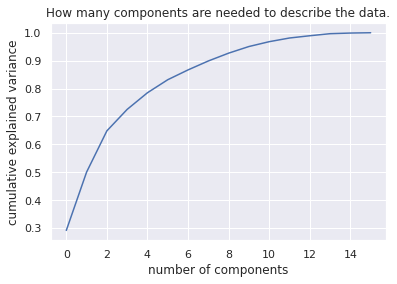

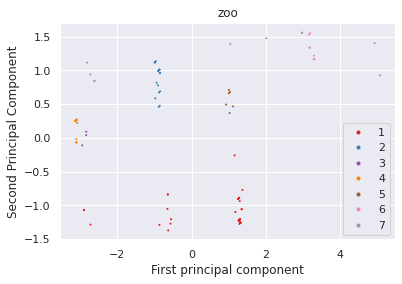

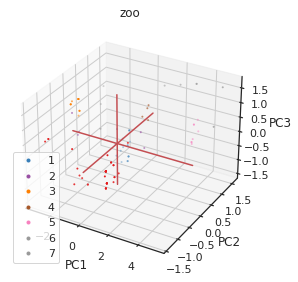

In [17]:
#visualizacion pca
cancer_pca = pca(df, titulo="zoo", label_y='class_type')
cancer_pca.pca_2D(); cancer_pca.pca_3D()

In [18]:
best_params = RKFold(X,y)

Best MAE: -0.17301
Best Config: {'sel__k': 10}
>-1.60242 with: {'sel__k': 2}
>-1.81352 with: {'sel__k': 3}
>-1.56609 with: {'sel__k': 4}
>-0.88101 with: {'sel__k': 5}
>-0.38752 with: {'sel__k': 6}
>-0.36003 with: {'sel__k': 7}
>-0.29261 with: {'sel__k': 8}
>-0.18068 with: {'sel__k': 9}
>-0.17301 with: {'sel__k': 10}
>-0.18505 with: {'sel__k': 11}
>-0.18637 with: {'sel__k': 12}
>-0.18882 with: {'sel__k': 13}
>-0.18826 with: {'sel__k': 14}
>-0.19186 with: {'sel__k': 15}
>-0.19766 with: {'sel__k': 16}


In [20]:
X_new = SelectKBest(chi2, k=10).fit_transform(X, y)

In [21]:
X_new.shape

(101, 10)

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.20,stratify=y, shuffle=True)
grid, df_grid, grid_report= Gridsearchcv(X_train, X_test, y_train, y_test)

Fitting 15 folds for each of 100 candidates, totalling 1500 fits


/home/nacho/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/nacho/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/nacho/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/nacho/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/nacho/anaconda3/lib/python3.9/site-pac

Best-Fit Parameters From Training Data:
 {'clf__selected_model': ('svc', {'C': 30, 'gamma': 0.1, 'kernel': 'rbf'})}
              precision  recall  f1-score  support
1                   1.0     1.0       1.0      8.0
2                   1.0     1.0       1.0      4.0
3                   1.0     1.0       1.0      1.0
4                   1.0     1.0       1.0      3.0
5                   1.0     1.0       1.0      1.0
6                   1.0     1.0       1.0      2.0
7                   1.0     1.0       1.0      2.0
accuracy            1.0     1.0       1.0      1.0
macro avg           1.0     1.0       1.0     21.0
weighted avg        1.0     1.0       1.0     21.0
[[8 0 0 0 0 0 0]
 [0 4 0 0 0 0 0]
 [0 0 1 0 0 0 0]
 [0 0 0 3 0 0 0]
 [0 0 0 0 1 0 0]
 [0 0 0 0 0 2 0]
 [0 0 0 0 0 0 2]]


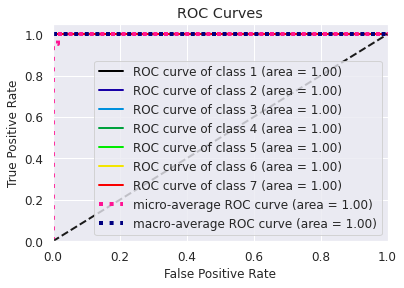

In [23]:
y_pred = grid.predict_proba(X_test)
skplt.metrics.plot_roc_curve(y_test, y_pred)
plt.show()

In [24]:
df_grid[:10]

,param_clf__selected_model,params,mean_fit_time,std_fit_time,mean_test_pr,std_test_pr,rank_test_pr,mean_test_rc,std_test_rc,rank_test_rc,mean_test_F1,std_test_F1,rank_test_F1,mean_test_acc,std_test_acc,rank_test_acc
40,"(svc, {'C': 30, 'gamma': 0.1, 'kernel': 'rbf'})","{'clf__selected_model': ('svc', {'C': 30, 'gam...",0.007209,0.001505,0.962500,0.038188,1,0.962500,0.038188,1,0.962500,0.038188,1,0.962500,0.038188,1
98,"(svc, {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'})","{'clf__selected_model': ('svc', {'C': 10, 'gam...",0.011438,0.002448,0.962500,0.038188,1,0.962500,0.038188,1,0.962500,0.038188,1,0.962500,0.038188,1
59,"(svc, {'C': 1000, 'gamma': 0.1, 'kernel': 'rbf'})","{'clf__selected_model': ('svc', {'C': 1000, 'g...",0.009691,0.001164,0.962500,0.038188,1,0.962500,0.038188,1,0.962500,0.038188,1,0.962500,0.038188,1
61,"(svc, {'C': 10, 'gamma': 0.07, 'kernel': 'rbf'})","{'clf__selected_model': ('svc', {'C': 10, 'gam...",0.010387,0.002054,0.954167,0.042492,4,0.954167,0.042492,4,0.954167,0.042492,4,0.954167,0.042492,4
39,"(svc, {'C': 1000, 'gamma': 0.07, 'kernel': 'rb...","{'clf__selected_model': ('svc', {'C': 1000, 'g...",0.007683,0.002947,0.954167,0.042492,4,0.954167,0.042492,4,0.954167,0.042492,4,0.954167,0.042492,4
83,"(svc, {'C': 40, 'gamma': 0.05, 'kernel': 'rbf'})","{'clf__selected_model': ('svc', {'C': 40, 'gam...",0.010159,0.002233,0.950000,0.040825,6,0.950000,0.040825,6,0.950000,0.040825,6,0.950000,0.040825,6
26,"(mlp, {'activation': 'tanh', 'alpha': 0.05, 'h...","{'clf__selected_model': ('mlp', {'activation':...",0.050594,0.016275,0.950000,0.040825,6,0.950000,0.040825,6,0.950000,0.040825,6,0.950000,0.040825,6
50,"(mlp, {'activation': 'relu', 'alpha': 0.05, 'h...","{'clf__selected_model': ('mlp', {'activation':...",0.330102,0.082664,0.950000,0.040825,6,0.950000,0.040825,6,0.950000,0.040825,6,0.950000,0.040825,6
38,"(mlp, {'activation': 'identity', 'alpha': 0.05...","{'clf__selected_model': ('mlp', {'activation':...",0.036758,0.008192,0.945833,0.038640,9,0.945833,0.038640,9,0.945833,0.038640,9,0.945833,0.038640,9
19,"(lr, {'C': 11.288378916846883, 'max_iter': 100...","{'clf__selected_model': ('lr', {'C': 11.288378...",0.047081,0.004828,0.945833,0.038640,9,0.945833,0.038640,9,0.945833,0.038640,9,0.945833,0.038640,9


In [77]:
df_grid['params'].values

array([{'clf__selected_model': ('svc', {'C': 30, 'gamma': 0.1, 'kernel': 'rbf'})},
       {'clf__selected_model': ('svc', {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'})},
       {'clf__selected_model': ('svc', {'C': 1000, 'gamma': 0.1, 'kernel': 'rbf'})},
       {'clf__selected_model': ('svc', {'C': 10, 'gamma': 0.07, 'kernel': 'rbf'})},
       {'clf__selected_model': ('svc', {'C': 1000, 'gamma': 0.07, 'kernel': 'rbf'})},
       {'clf__selected_model': ('svc', {'C': 40, 'gamma': 0.05, 'kernel': 'rbf'})},
       {'clf__selected_model': ('mlp', {'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (7,), 'learning_rate': 'constant', 'solver': 'lbfgs'})},
       {'clf__selected_model': ('mlp', {'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (5,), 'learning_rate': 'adaptive', 'solver': 'lbfgs'})},
       {'clf__selected_model': ('mlp', {'activation': 'identity', 'alpha': 0.05, 'hidden_layer_sizes': (10,), 'learning_rate': 'constant', 'solver': 'lbfgs'})},
       {'clf__selected

In [40]:
df_grid.iloc[0].transpose()[[0,2,10,7,-3,4]]

param_clf__selected_model    (svc, {'C': 30, 'gamma': 0.1, 'kernel': 'rbf'})
mean_fit_time                                                       0.007209
mean_test_F1                                                          0.9625
mean_test_rc                                                          0.9625
mean_test_acc                                                         0.9625
mean_test_pr                                                          0.9625
Name: 40, dtype: object

In [78]:
df_grid.iloc[1].transpose()[[0,2,10,7,-3,4]]

param_clf__selected_model    (svc, {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'})
mean_fit_time                                                       0.011438
mean_test_F1                                                          0.9625
mean_test_rc                                                          0.9625
mean_test_acc                                                         0.9625
mean_test_pr                                                          0.9625
Name: 98, dtype: object

In [79]:
df_grid.iloc[2].transpose()[[0,2,10,7,-3,4]]

param_clf__selected_model    (svc, {'C': 1000, 'gamma': 0.1, 'kernel': 'rbf'})
mean_fit_time                                                         0.009691
mean_test_F1                                                            0.9625
mean_test_rc                                                            0.9625
mean_test_acc                                                           0.9625
mean_test_pr                                                            0.9625
Name: 59, dtype: object